# Exercício em Python - Tema 2 - Tendências em séries temporais

Este exercício tem por objetivo avaliar estatisticamente as tendências de precipitação, aplicadas para a base de dados do CABra, contendo 735 bacias hidrográficas com os valores de precipitações diários de outubro de 1980 a setembro de 2010 (30 anos hidrológicos). Para quantificar tais alterações, serão utilizados o teste de Mann-Kendall e o estimador de declive de Sen.

Vamos aqui aplicar o teste de Mann-Kendall e o estimador de declive de Sen para a Bacia 1. A análise de tendências passa pelas escalas anual e mensal, comparando-se os mesmos períodos de 1980 a 2010.

##1. Importação de bibliotecas.



In [ ]:
pip install pymannkendall

In [ ]:
import pathlib
import pandas as pd
import numpy as np
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
import pymannkendall as mk
from numpy.ma.core import mean
from IPython.core.pylabtools import figsize
import io
import requests

##2. Importação dos dados do CABra

In [ ]:
#Escolha da bacia e base de dados (no caso, "ensemble")
bacia1 = "1"
base1 = "ens"
base2 = "ENS"

url = ("https://raw.githubusercontent.com/brunokenmarchezepe/CABra_exercicios/main/CABRA_dataset/CABra_climate_daily_series/" + base1 + "/CABra_" + bacia1 + "_climate_" + base2 + ".txt")

bacia_df = requests.get(url).content
bacia_df = pd.read_csv(io.StringIO(bacia_df.decode('utf-8', errors = 'ignore')),
                 skiprows = 13,
                 delimiter='\t')

bacia_df.columns = ['Year', 'Month', 'Day', 'p', 'tmin', 'tmax', 'rh', 'wnd', 'srad', 'et', 'pet_pm','pet_pt', 'pet_hg']
bacia_df.head()


,Year,Month,Day,p,tmin,tmax,rh,wnd,srad,et,pet_pm,pet_pt,pet_hg
0,,,,mm,C,C,%,m s,MJ m,mm,mm,mm,mm
1,1980,1,1,17.744,20.745,27.849,89.784,1.068,11.593,3.928,3.139,3.652,2.700
2,1980,1,2,6.515,20.510,29.676,84.342,0.522,16.139,4.038,4.082,4.934,3.825
3,1980,1,3,4.314,21.578,30.517,84.951,0.820,17.680,4.202,4.523,5.406,4.262
4,1980,1,4,3.955,22.022,31.363,82.714,1.012,16.178,4.729,4.318,5.017,3.963


In [ ]:
#Exclui linha 0 pois não faz parte dos dados
bacia_df = bacia_df.drop([0], axis=0)

In [ ]:
#Passando todos os dados para categoria numérica
bacia_df = bacia_df.apply(pd.to_numeric)
bacia_df.head()

,Year,Month,Day,p,tmin,tmax,rh,wnd,srad,et,pet_pm,pet_pt,pet_hg
1,1980,1,1,17.744,20.745,27.849,89.784,1.068,11.593,3.928,3.139,3.652,2.700
2,1980,1,2,6.515,20.510,29.676,84.342,0.522,16.139,4.038,4.082,4.934,3.825
3,1980,1,3,4.314,21.578,30.517,84.951,0.820,17.680,4.202,4.523,5.406,4.262
4,1980,1,4,3.955,22.022,31.363,82.714,1.012,16.178,4.729,4.318,5.017,3.963
5,1980,1,5,4.798,21.741,30.880,82.440,1.134,17.508,3.945,4.597,5.379,4.256


###2.1.	Escolha de escala temporal

In [ ]:
#Conversão de colunas de data para formato "dtype"
cols=["Year","Month","Day"]
bacia_df['date'] = bacia_df[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
bacia_df['date']=pd.to_datetime(bacia_df['date'])

In [ ]:
#Caso se deseje, utilizar dados a partir de determinado ano, mês e dia
data_base = '1980-01-01'
bacia_df = bacia_df[bacia_df.date >= data_base]
bacia_df.head()

,Year,Month,Day,p,tmin,tmax,rh,wnd,srad,et,pet_pm,pet_pt,pet_hg,date
2,1980,1,2,6.515,20.510,29.676,84.342,0.522,16.139,4.038,4.082,4.934,3.825,1980-01-02
3,1980,1,3,4.314,21.578,30.517,84.951,0.820,17.680,4.202,4.523,5.406,4.262,1980-01-03
4,1980,1,4,3.955,22.022,31.363,82.714,1.012,16.178,4.729,4.318,5.017,3.963,1980-01-04
5,1980,1,5,4.798,21.741,30.880,82.440,1.134,17.508,3.945,4.597,5.379,4.256,1980-01-05
6,1980,1,6,5.041,22.282,30.568,85.057,1.103,14.802,4.175,3.966,4.615,3.605,1980-01-06


In [ ]:
#Caso se deseje, utilizar ano hidrológico (1/10 a 30/09)
bacia_df['water_year'] = bacia_df.date.dt.year.where(bacia_df.date.dt.month < 10, bacia_df.date.dt.year + 1)
bacia_df.head()

,Year,Month,Day,p,tmin,tmax,rh,wnd,srad,et,pet_pm,pet_pt,pet_hg,date,water_year
1,1980,1,1,17.744,20.745,27.849,89.784,1.068,11.593,3.928,3.139,3.652,2.700,1980-01-01,1980
2,1980,1,2,6.515,20.510,29.676,84.342,0.522,16.139,4.038,4.082,4.934,3.825,1980-01-02,1980
3,1980,1,3,4.314,21.578,30.517,84.951,0.820,17.680,4.202,4.523,5.406,4.262,1980-01-03,1980
4,1980,1,4,3.955,22.022,31.363,82.714,1.012,16.178,4.729,4.318,5.017,3.963,1980-01-04,1980
5,1980,1,5,4.798,21.741,30.880,82.440,1.134,17.508,3.945,4.597,5.379,4.256,1980-01-05,1980


##3. Análise Anual

In [ ]:
#Soma de dados diários para ter dados anuais
tipo_ano = 'Year' #Pode-se escolher 'water_year' para utilizar o ano hidrológico
bacia_ano = bacia_df.pivot_table('p', [tipo_ano], aggfunc='sum').reset_index()
bacia_ano.head()

,Year,p
0,1980,1973.229
1,1981,2109.139
2,1982,2140.691
3,1983,1845.893
4,1984,2225.567


###3.1 Cálculo de Tendências

In [ ]:
#Teste de Mann-Kendall e Estimador de Declive de Sen
MK_SEN = mk.original_test(bacia_ano.p)

print(MK_SEN)

Mann_Kendall_Test(trend='no trend', h=False, p=0.18493228677225515, z=-1.3257205233813756, Tau=-0.16989247311827957, s=-79.0, var_s=3461.6666666666665, slope=-3.7834761904761893, intercept=2106.572142857143)


In [ ]:
#Cálculo do Sen's Slope em porcentagem

SEN = round(MK_SEN.slope, 2)
SEN_P = round(100* SEN / mean(bacia_ano.p), 2)

if MK_SEN.h == True:
  print("Há tendência significativa do tipo ", MK_SEN.trend, " e o declive é ", SEN, "mm/ano, o que equivale a ", SEN_P, "% da precipitação anual média da bacia por ano")
else:
  print("O declive é ", SEN, "mm/ano, o que equivale a ", SEN_P, "% da precipitação anual média da bacia por ano")

O declive é  -3.78 mm/ano, o que equivale a  -0.18 % da precipitação anual média da bacia por ano


###3.2. Plotagem dos Resultados

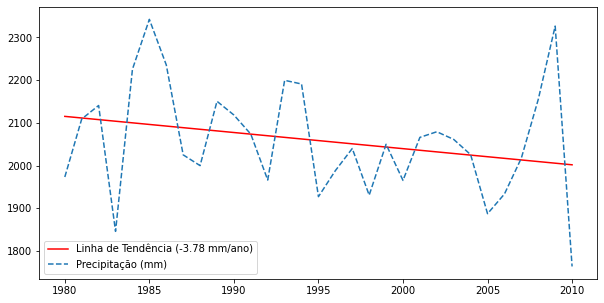

In [ ]:
#Ajustes para visualização do gráfico centralizado na figura
pt = (1995, mean(bacia_ano.p))
b = pt[1] - SEN * pt[0]

pt1 = (pt[0] - 15, SEN * (pt[0] - 15) + b)
pt2 = (pt[0] + 15, SEN * (pt[0] + 15) + b)

#Insere um asterisco se a tendência for estatisticamente significante segundo o teste de Mann-Kendall
if MK_SEN.trend != 'no trend':
    ast = '*'
else:
    ast = ''

text = 'Linha de Tendência (' + str(SEN) + ' mm/ano' + str(ast) + ')'

plt.figure(figsize=(10,5))
plt.plot((pt1[0], pt2[0]), (pt1[1], pt2[1]), 'r', label= text)
plt.plot(bacia_ano.Year, bacia_ano.p, linestyle="--", label="Precipitação (mm)")
plt.legend()
plt.show()

##4. Análise Mensal

In [ ]:
#Soma de dados diários para ter dados mensais
tipo_ano = 'Year' #Pode-se escolher 'water_year' para utilizar o ano hidrológico
bacia_mes = bacia_df.pivot_table('p', [tipo_ano, 'Month'], aggfunc='sum').reset_index()
bacia_mes.head()

,Year,Month,p
0,1980,1,260.216
1,1980,2,248.167
2,1980,3,295.678
3,1980,4,147.195
4,1980,5,110.272


###Cálculo de Tendências

In [ ]:
#Nome dos meses
meses = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']

#Definindo um data frame para alocar os resultados de cada mês
MK_SEN_mes = pd.DataFrame(columns=['month','month_name', 'mk', 'sen',  'sen_p'])

#Cálculo das tendências
for i in range(1,13):

  ab_mes = bacia_mes[bacia_mes.Month == i]

  #Teste de Mann-Kendall e Estimador de Declive de Sen
  MK_SEN = mk.original_test(ab_mes.p)

  #Cálculo do Sen's Slope
  SEN = round(MK_SEN.slope, 2)
  SEN_P = round(100* SEN / mean(ab_mes.p), 2)

  MK_SEN_mes.loc[i] = [i, meses[i-1], MK_SEN.trend, SEN, SEN_P]

  if MK_SEN.h == True:
    print("Há tendência significativa no mês de ", meses[i-1],", do tipo ", MK_SEN.trend, " e o declive é ", SEN, "mm/ano, o que equivale a ", SEN_P, "% da precipitação mensal média da bacia por ano")
  else:
    print("Não há tendência significativa no mês de ", meses[i-1]," e o declive é ", SEN, "mm/ano, o que equivale a ", SEN_P, "% da precipitação mensal média da bacia por ano")

Não há tendência significativa no mês de  Janeiro  e o declive é  0.11 mm/ano, o que equivale a  0.04 % da precipitação mensal média da bacia por ano
Não há tendência significativa no mês de  Fevereiro  e o declive é  -0.09 mm/ano, o que equivale a  -0.03 % da precipitação mensal média da bacia por ano
Não há tendência significativa no mês de  Março  e o declive é  -0.23 mm/ano, o que equivale a  -0.08 % da precipitação mensal média da bacia por ano
Não há tendência significativa no mês de  Abril  e o declive é  -0.99 mm/ano, o que equivale a  -0.48 % da precipitação mensal média da bacia por ano
Não há tendência significativa no mês de  Maio  e o declive é  -0.4 mm/ano, o que equivale a  -0.34 % da precipitação mensal média da bacia por ano
Não há tendência significativa no mês de  Junho  e o declive é  -0.43 mm/ano, o que equivale a  -0.74 % da precipitação mensal média da bacia por ano
Não há tendência significativa no mês de  Julho  e o declive é  -0.45 mm/ano, o que equivale a  -1

###Plotagem dos Gráficos

In [ ]:
MK_SEN_mes

,month,month_name,mk,sen,sen_p
1,1,Janeiro,no trend,0.11,0.04
2,2,Fevereiro,no trend,-0.09,-0.03
3,3,Março,no trend,-0.23,-0.08
4,4,Abril,no trend,-0.99,-0.48
5,5,Maio,no trend,-0.40,-0.34
6,6,Junho,no trend,-0.43,-0.74
7,7,Julho,no trend,-0.45,-1.11
8,8,Agosto,decreasing,-0.80,-1.38
9,9,Setembro,no trend,-0.98,-0.94
10,10,Outubro,no trend,0.12,0.07


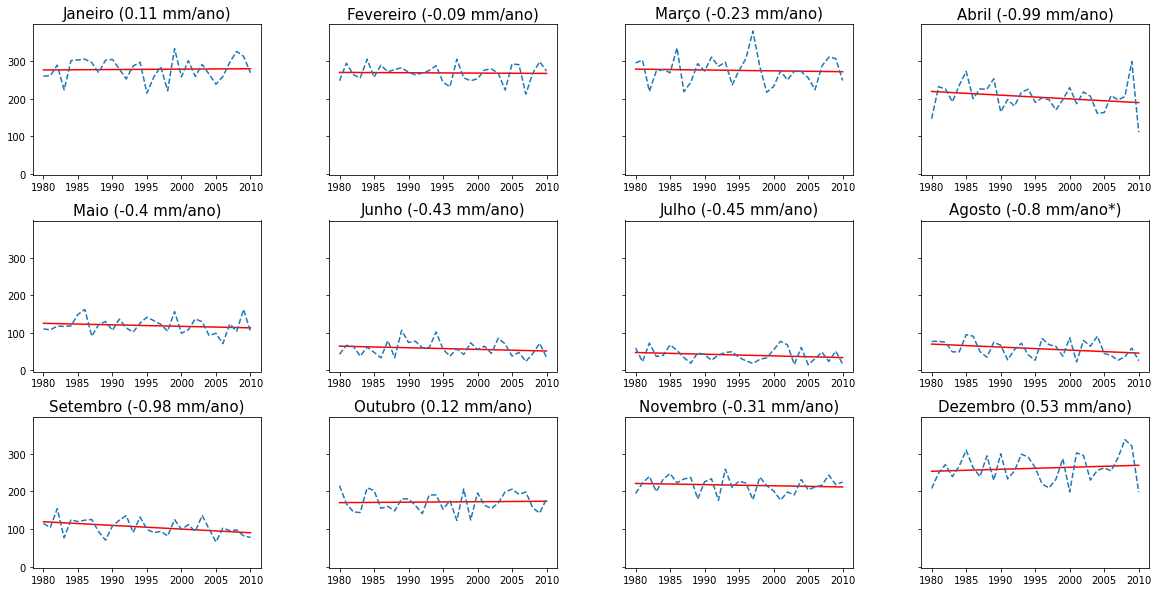

In [ ]:
rows, cols = 3, 4
fig, ax = plt.subplots(rows, cols,
                       sharey='all',
                       figsize=(20,10))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

i=1
for row in range(rows):
    for col in range(cols):
        ab_mes = bacia_mes[bacia_mes.Month == i]
        pt = (1995, mean(ab_mes.p))
        b = pt[1] - MK_SEN_mes.sen[i] * pt[0]

        pt1 = (pt[0] - 15, MK_SEN_mes.sen[i] * (pt[0] - 15) + b)
        pt2 = (pt[0] + 15, MK_SEN_mes.sen[i] * (pt[0] + 15) + b)

        #Insere um asterisco se a tendência for estatisticamente significante segundo o teste de Mann-Kendall
        if MK_SEN_mes.mk[i] != 'no trend':
          ast = '*'
        else:
          ast = ''

        ax[row,col].plot((pt1[0], pt2[0]), (pt1[1], pt2[1]), 'r')
        ax[row,col].plot(ab_mes.Year, ab_mes.p, linestyle="--")
        #title = meses[i-1] + ' (' + MK_SEN_mes.sen[i] + ' mm/ano)'
        t1 = str(meses[i-1])
        t2 = str(MK_SEN_mes.sen[i])
        ax[row,col].set_title(t1 + ' (' + t2 + ' mm/ano' + ast + ')',
                              fontsize=15,
                               loc = 'center')

        i = i+1

plt.show()